# Fine Tuning T5 for Summarization Task

@hyyoka

---



## Introduction

In this tutorial we will be fine tuning a transformer model for **Summarization Task**. 
In this task a summary of a given article/document is generated when passed through a network. There are 2 types of summary generation mechanisms:

1. ***Extractive Summary:*** the network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.
2. ***Abstractive Summary***: The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article. 

In this tutorial we will be generating ***Abstractive Summary*** using one of the most recent and novel transformers model ***T5***. [Paper](https://arxiv.org/abs/1910.10683)   
- **T5** is a unified framework that converts every language problem into a text-to-text format. 
    - **Text-2-Text** </br>
    All NLP tasks are converted to a **text-to-text** problem. Tasks such as translation, classification, summarization and question answering, all of them are treated as a text-to-text conversion problem, rather than seen as separate unique problem statements.
    - **Unified approach for NLP Deep Learning** </br> 
    Since the task is reflected purely in the text input and output, you can use the same model, objective, training procedure, and decoding process to ANY task. 
- We will be taking inputs from the T5 paper to prepare our dataset prior to fine tuning and training.    
- [Documentation for python](https://huggingface.co/transformers/model_doc/t5.html)

![**Each NLP problem as a “text-to-text” problem** - input: text, output: text](https://miro.medium.com/max/4006/1*D0J1gNQf8vrrUpKeyD8wPA.png) 
    

## Points in T5

1. What is text-to-text?
2. Model structure
3. Training objective: Modified MLM




### 1. What is text-to-text?
> Text 형태로 주어진 문제에서 Text 정답 찾기

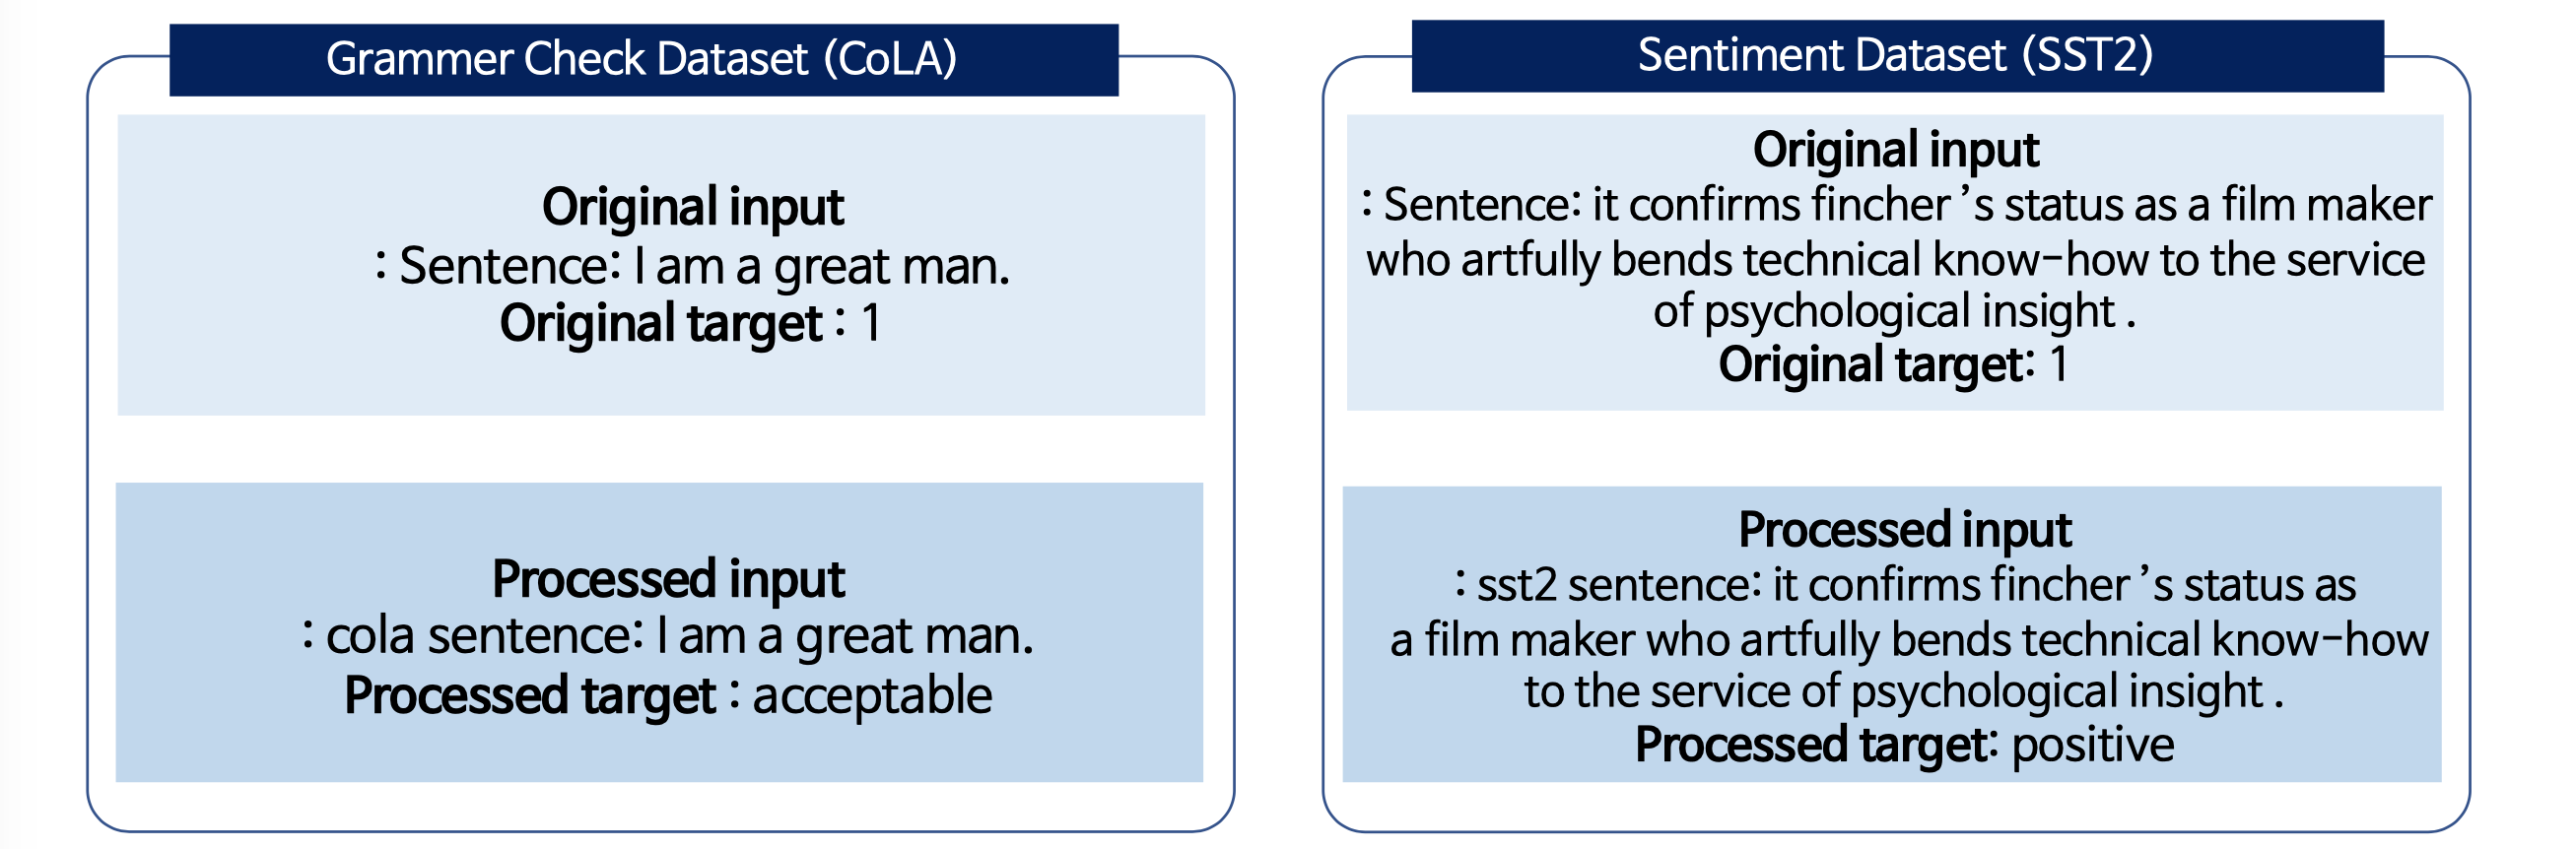

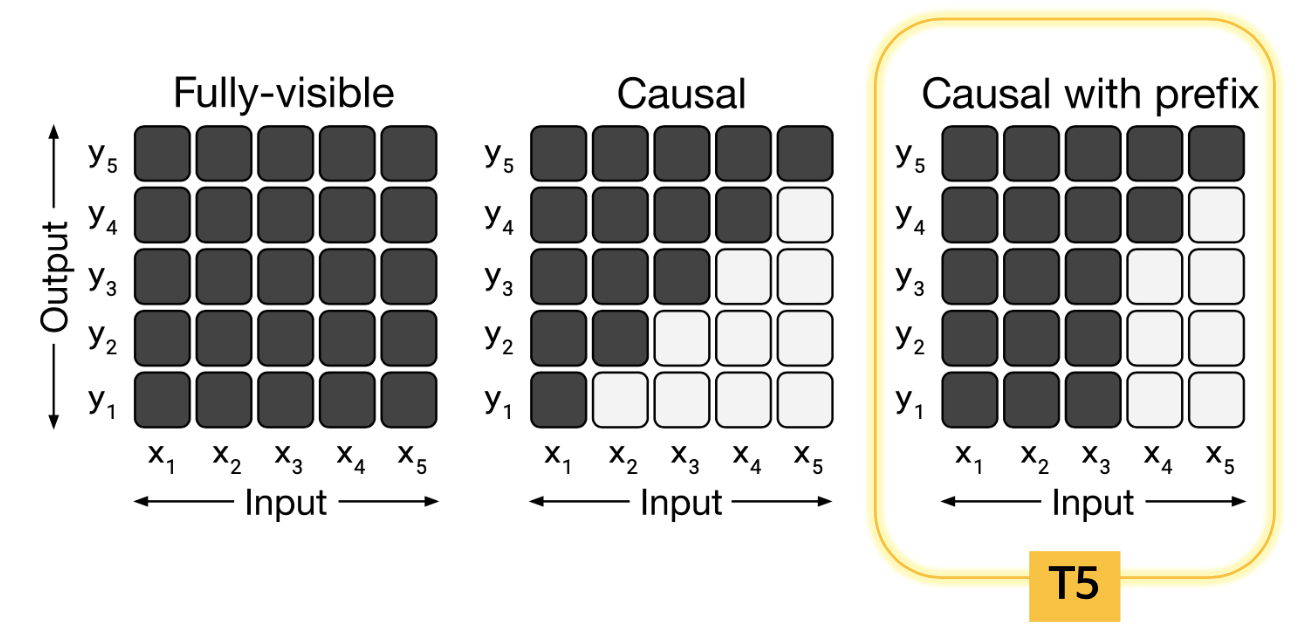

### 2. Model Structure
- Encoder-Decoder model 

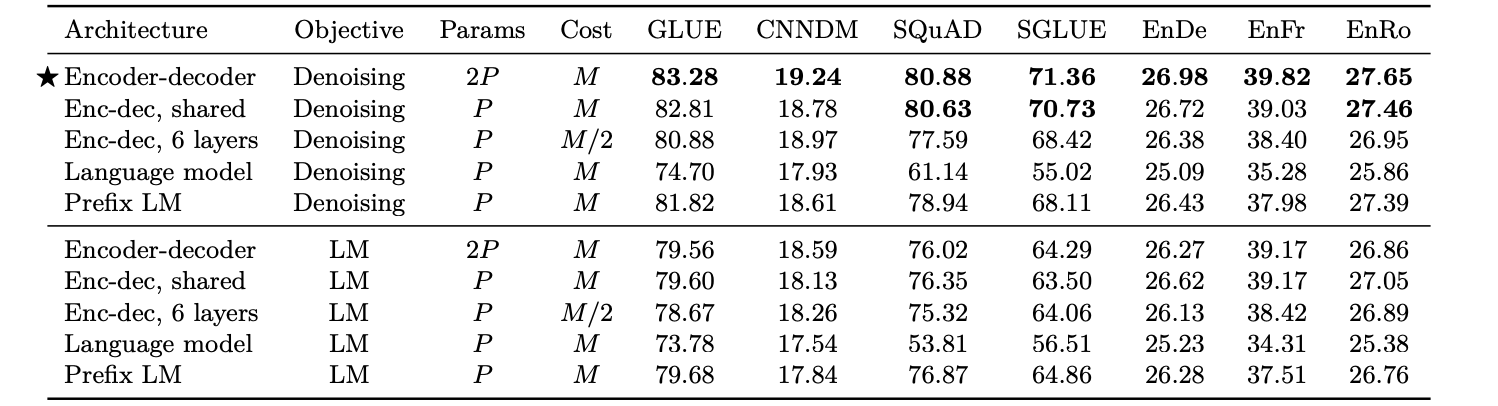

### 3. Training Objectives: Modified MLM

- Pretraining에서 Noising된 Input을 Denoising하며 단어를 예측하는 방식이 가장 효율적임 : 즉, Denoising AE라 볼 수 있음

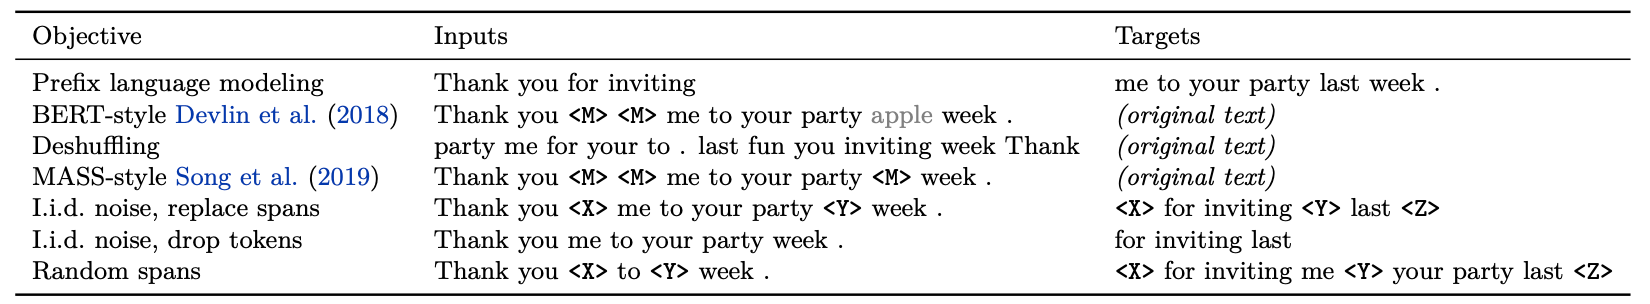


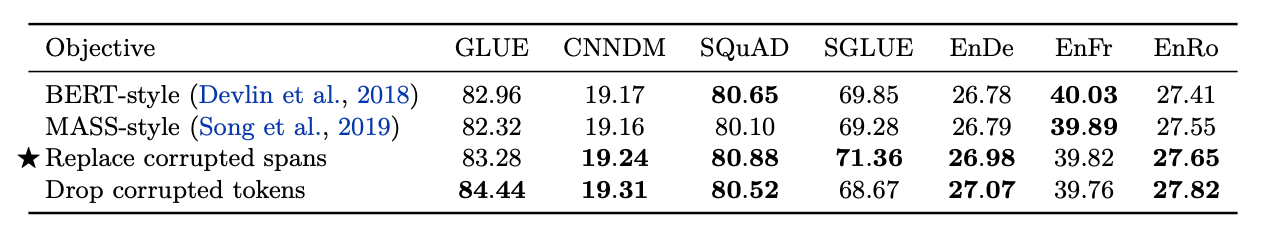

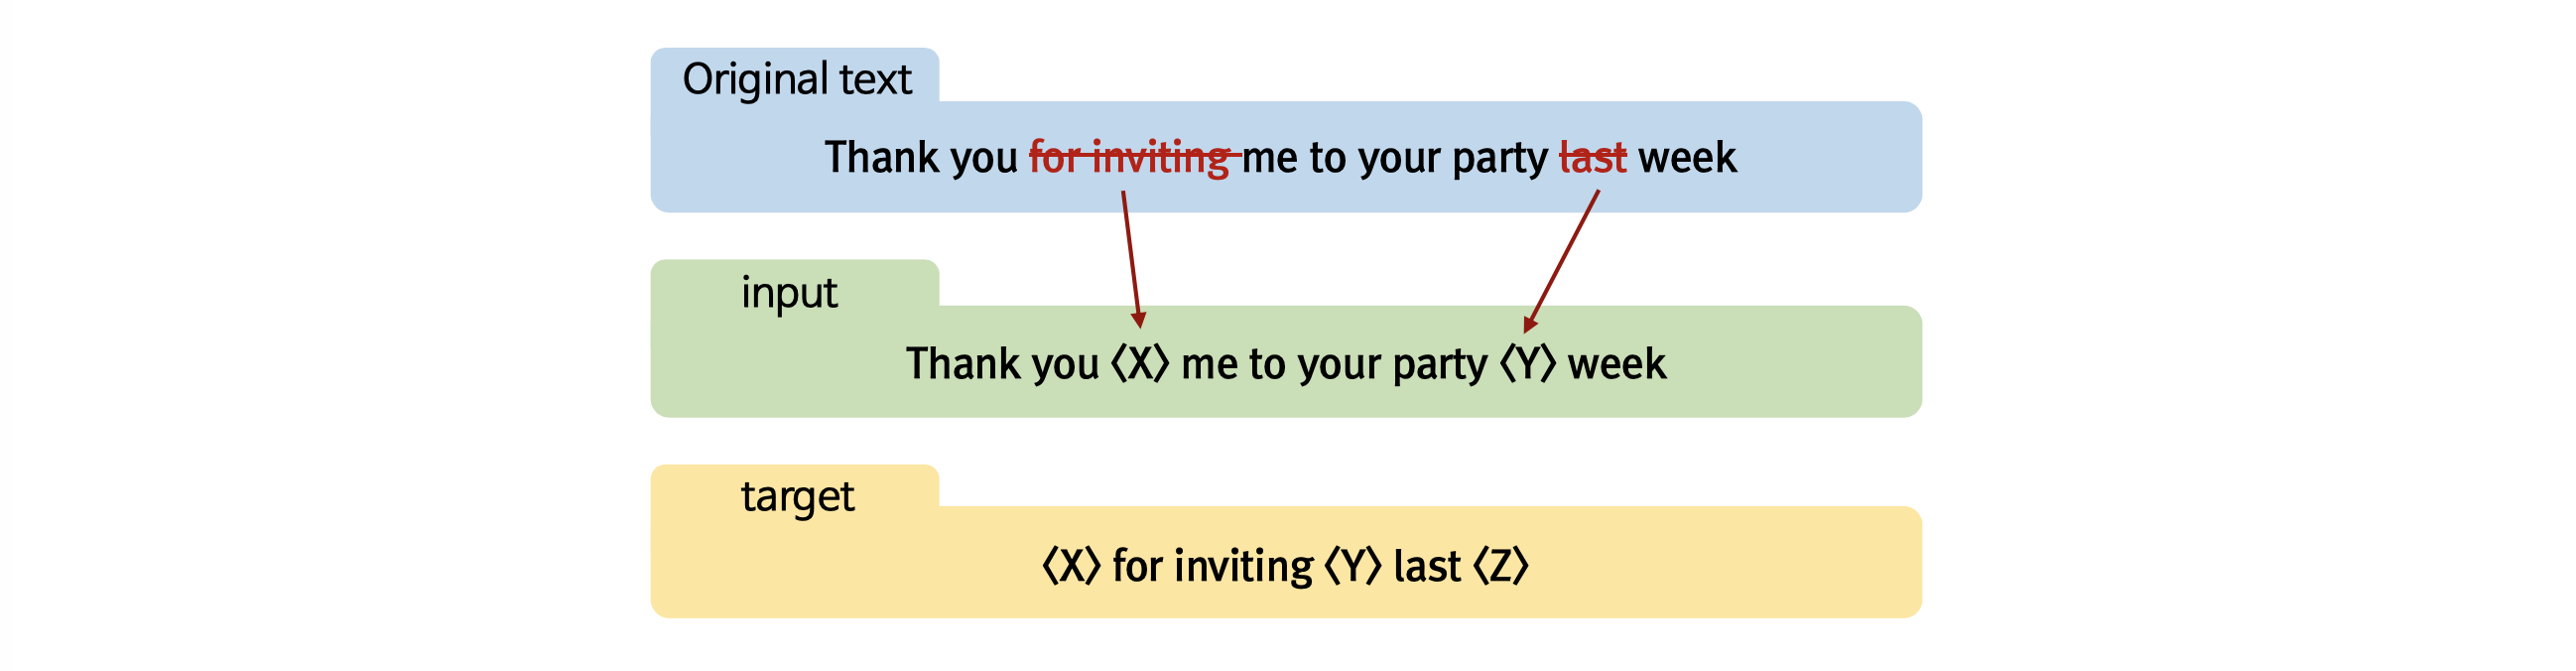

- T5는 연속된 token(fragment)를 하나의 mask로 바꿈
- output level에서 FFNN+Softmax를 통해 시퀀스 생성

그 밖에도 여러 실험을 통해 다음과 같은 결론을 얻었다,  
- Corruption rate는 15%가 가장 적절함
- Corrupted span length는 3이 적절함
- Unlabeled dataset: Domain specific data는 task에 도움이 되지만 데이터의 크기가 작은 경우 overfitting을 야기함
- Multi-task pre-training
    - Multi-task pre-training도 unsupervised task alone과 유사한 성능을 보임
    - Task의 비율을 잘 설정해야함
- Scaling
    - 모델 크기를 늘리거나, 앙상블을 시도하며 실험 진행
    - 작은 모델을 큰 데이터로 학습하는게 효과적이라는 결론


---

 .

## Finetuning
1. 필요한 모듈 임포트
2. Dataset 정의 - DataLoader에 올리기
3. 모델 Finetuner 정의
4. Trainer를 이용해 학습
5. 실험

In [ ]:
!pip install transformers pytorch_lightning datasets sentencepiece rouge_score

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 849kB 23.5MB/s 
     |████████████████████████████████| 204kB 20.7MB/s 
     |████████████████████████████████| 1.2MB 27.1MB/s 
     |████████████████████████████████| 901kB 38.7MB/s 
     |████████████████████████████████| 3.3MB 38.2MB/s 
     |████████████████████████████████| 276kB 36.8MB/s 
     |████████████████████████████████| 829kB 42.9MB/s 
     |████████████████████████████████| 112kB 40.0MB/s 
     |████████████████████████████████| 276kB 39.8MB/s 
     |████████████████████████████████| 245kB 39.7MB/s 
     |████████████████████████████████| 1.3MB 39.2MB/s 
     |████████████████████████████████| 143kB 43.2MB/s 
     |████████████████████████████████| 296kB 37.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=a446b2ea4607221c6e17c1f4033a357587b0b9e45569d41437d94564c4c266c7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51d

In [ ]:
import argparse

import glob
import os
import json
import time
import logging
import random

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from datasets import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

## Load Data

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from datasets import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='/content/gdrive/MyDrive/data/')

Using custom data configuration all-1050b013d61c8a57


Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all-1050b013d61c8a57/1.2.0/3285d112e2b5e126402f94db3dc8c6ba53fc403e80b93bd1494a44c7ea7e9481. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys())

dict_keys(['train', 'validation', 'test'])


In [ ]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (157252, 3)


In [ ]:
print("Size of Validation dataset: ", dataset['validation'].shape)

Size of Validation dataset:  (5599, 3)


In [ ]:
print("Size of ca test dataset: ", dataset['test'].shape)

Size of ca test dataset:  (5577, 3)


### Look at Examples in this data set

In [ ]:
print(dataset['train'][0].keys())

dict_keys(['headline', 'text', 'title'])


In [ ]:
print(" Example of text: ", dataset['train'][2]['text'])

 Example of text:  It is possible to become a VFX artist without a college degree, but the path is often easier with one. VFX artists usually major in fine arts, computer graphics, or animation. Choose a college with a reputation for strength in these areas and a reputation for good job placement for graduates. The availability of internships is another factor to consider.Out of the jobs advertised for VFX artists, a majority at any given time specify a bachelor’s degree as a minimum requirement for applicants.;
, Some studios offer short-term programs for people who want to learn more about VFX artistry without pursuing a college degree. Enrolling in these programs can be expensive as financial aid isn’t always offered, but they usually have the most cutting edge technology for you to learn from., Although you may create some hand sketches, the majority of your work will be completed on the computer using the most up-to-date programs. Stay informed about the newest software advances b

In [ ]:
print(" Example of Summary: ", dataset['train'][0]['headline'])

 Example of Summary:  Keep related supplies in the same area.
Make an effort to clean a dedicated workspace after every session.
Place loose supplies in large, clearly visible containers.
Use clotheslines and clips to hang sketches, photos, and reference material.
Use every inch of the room for storage, especially vertical space.
Use chalkboard paint to make space for drafting ideas right on the walls.
Purchase a label maker to make your organization strategy semi-permanent.
Make a habit of throwing out old, excess, or useless stuff each month.


In [ ]:
print(" Example of Title: ", dataset['train'][0]['title'])

 Example of Title:  How to Be an Organized Artist1


## Define a DataSet class for the loader

In [ ]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='/content/gdrive/MyDrive/data', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '') 
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        # sentence pair
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        
  

### Test the dataset function

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

Using custom data configuration all-6bfd8c56901adbb3


Dataset wikihow downloaded and prepared to /root/.cache/huggingface/datasets/wikihow/all-6bfd8c56901adbb3/1.2.0/3285d112e2b5e126402f94db3dc8c6ba53fc403e80b93bd1494a44c7ea7e9481. Subsequent calls will reuse this data.


5599

In [ ]:
data = dataset[3]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  You and your guinea pig will not reach the harder stuff without knowing everything that you should know about training first. First, work on targeting, conditioning your pig to the clicker, and doing simple tricks, such as Stand Up. Just because a trick doesn't necessarily exist doesn't mean you can't teach it to your piggy anyway. Make up your own tricks, use your mind, and have fun with it! If you are both bored out of your minds, there is no point in training at all.Make very low hurdles-no more than two inches off the ground at the most-and teach your guinea pig to jump over them, create a safe agility course, or use lures to train your piggy to jump through a hoop. The possibilities are endless!, I've said it once, I'll say it again; guinea pigs are much more fragile than the average dog or cat, so almost every trick meant for a larger animal must be adapted to suit the needs of a guinea pig.Ensure that there is nothing to endanger your piggy before, during, or after 

In [ ]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return wikihow(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

## Define Model

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        # self.rouge_metric = load_metric('rouge') 

        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))

    def is_logger(self):
        return self.trainer.global_rank <= 0
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}


    ### DataLoader

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)


    #### 학습
    def forward(
      self, 
      input_ids,  # Indices of input sequence tokens in the vocabulary. 
      attention_mask=None, # Mask to avoid performing attention on padding token indices
      decoder_input_ids=None, # T5 uses the pad_token_id as the starting token for decoder_input_ids generation.
      decoder_attention_mask=None, 
      lm_labels=None # Labels for computing the sequence classification/regression loss (see T5Model). Note: loss is returned when lm_label is provided.
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
    )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}


    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        
        return base_metrics
    

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        

    #### Optimizer
    
    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False, on_tpu=False, using_lbfgs=False):
        optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict


In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

## Define Arguments

In [ ]:
args_dict = dict(
    output_dir="\content", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_input_length=512,
    max_output_length=150,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=2,
    eval_batch_size=2,
    num_train_epochs=1,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [ ]:
args_dict.update({'output_dir': 't5_wikihow', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'output_dir': 't5_wikihow', 'model_name_or_path': 't5-small', 'tokenizer_name_or_path': 't5-small', 'max_input_length': 512, 'max_output_length': 150, 'freeze_encoder': False, 'freeze_embeds': False, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 4, 'eval_batch_size': 4, 'num_train_epochs': 2, 'gradient_accumulation_steps': 8, 'n_gpu': 1, 'resume_from_checkpoint': None, 'val_check_interval': 0.05, 'n_val': 1000, 'n_train': -1, 'n_test': -1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
# Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=3)


## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=1,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    callbacks=[LoggingCallback()],
)

## Train Model

In [ ]:
model = T5FineTuner(args)

In [ ]:
trainer = pl.Trainer(**train_params)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

## Check Model Predictions

In [ ]:
import textwrap
from tqdm.auto import tqdm

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'test', None, 512, 150, False)

Using custom data configuration all-6bfd8c56901adbb3
Reusing dataset wikihow (/root/.cache/huggingface/datasets/wikihow/all-6bfd8c56901adbb3/1.2.0/3285d112e2b5e126402f94db3dc8c6ba53fc403e80b93bd1494a44c7ea7e9481)


In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

In [ ]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [ ]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

dec = [tokenizer.decode(ids) for ids in outs]
texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
for i in range(5):
    lines = textwrap.wrap("WikiHow Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Summary: %s" % targets[i])
    print("\nPredicted Summary: %s" % dec[i])
    print("=====================================================================\n")

WikiHow Text: You should always begin with the end in mind when it comes to planning a presentation.
Think about what you're trying to convey, and the best means to do so in the time you have.Try
jotting down your most important points. See if you notice a key point emerging. If you wanted your
audience to take away one thing from this presentation, what would it be?Presentations often involve
sharing information. However, it isn't enough to just bombard your audience with facts. What do
these facts do? What bigger point are you making with the information you have?;, Your audience will
come into the presentation with certain expectations. Know a bit about your audience, their
background, and their beliefs. This can help you structure your presentation based around audience
needs.One major question is, How much background information will my audience have about this topic?
You need to be able to fill in some blanks for the audience, so keep in mind what your audience may
not know.Also,